In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import copy
import numpy as np
import os

p1 = 0.4
p2 = 0.7
p3 = 1
gamma = 0.01      # learning rate
num_epochs = 100000
lambda_reg = 0.005  # regularization weight
eps = 1e-6  # threshold for counting nonzeros
incl_bias_sparsity = True # whether or not to include and penalize biases in the sparsity measure
save_figs = True # optional: save plots as .png

torch.manual_seed(20)

# Dataset: 10 random 50-dimensional points and random scalar labels
N, D = 10, 50
K = N*10           # number of hidden units
x_train = torch.zeros(N, D)
x_train.uniform_(-1, 1) 
y_train = torch.zeros(N, 1) 
y_train.uniform_(-1, 1)

# for saving figures
if save_figs:
    fig_dir = 'figs/high_d/'
    if not os.path.exists(fig_dir):
        os.makedirs(fig_dir)

In [2]:
# Define single-hidden-layer ReLU network
class ReLURegNet(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        # hidden layer weights w_k and biases b_k
        self.hidden = nn.Linear(input_dim, hidden_dim, bias=True)
        # output weights v_k (no bias)
        self.output = nn.Linear(hidden_dim, 1, bias=False)
        self.relu = nn.ReLU()

    def forward(self, x):
        z = self.hidden(x)        # pre-activations [N, K]
        h = self.relu(z)          # activations [N, K]
        out = self.output(h)      # output [N, 1]
        return out, z

In [3]:
# Instantiate models
model_none = ReLURegNet(D, K)
model_wd = copy.deepcopy(model_none)
model_p1 = copy.deepcopy(model_none)
model_p2 = copy.deepcopy(model_none)
model_p3 = copy.deepcopy(model_none)

# Optimizers
opt_none = optim.Adam(model_none.parameters(), lr=gamma)
opt_wd = optim.AdamW(model_wd.parameters(), lr=gamma, weight_decay=lambda_reg)
opt_p1 = optim.Adam(model_p1.parameters(), lr=gamma)
opt_p2 = optim.Adam(model_p2.parameters(), lr=gamma)
opt_p3 = optim.Adam(model_p3.parameters(), lr=gamma)

criterion = nn.MSELoss()

# History storage
epochs = []
metrics = {
    'none': {'mse': [], 'spars': [], 'act': []},
    'wd': {'mse': [], 'spars': [], 'act': []},
    'p1': {'mse': [], 'spars': [], 'act': [], 'lp': []},
    'p2': {'mse': [], 'spars': [], 'act': [], 'lp': []},
    'p3': {'mse': [], 'spars': [], 'act': [], 'lp': []},
}

# Utility: lp path norm
def lp_path_norm(model, p):
    if incl_bias_sparsity:
        W = torch.cat((model.hidden.weight, model.hidden.bias[:, None]), dim=1)
    else:
        W = model.hidden.weight
    V = model.output.weight.view(-1, 1)
                  
    return (W*V).abs().pow(p).sum().item()

# Utility: count nonzeros (l0 path norm)
def count_nonzero(model):
    if incl_bias_sparsity:
        W = torch.cat((model.hidden.weight, model.hidden.bias[:, None]), dim=1)
    else:
        W = model.hidden.weight
    V = model.output.weight.view(-1, 1)
                  
    return int((W * V).abs().gt(eps).sum().item())

# Utility: count active neurons
def count_active_neurons(model):
    if incl_bias_sparsity:
        W = torch.cat((model.hidden.weight, model.hidden.bias[:, None]), dim=1)
    else:
        W = model.hidden.weight
    V = model.output.weight.view(-1, 1)
                  
    return int(((W*V).abs().ge(eps).any(dim=1)).sum().item())

In [4]:
# Training loop
for epoch in range(1, num_epochs+1):
    # No regularization
    opt_none.zero_grad()
    y_none, _ = model_none(x_train)
    loss_none = criterion(y_none, y_train)
    loss_none.backward(); opt_none.step()

    # AdamW
    opt_wd.zero_grad()
    y_wd, _ = model_wd(x_train)
    loss_wd = criterion(y_wd, y_train)
    loss_wd.backward(); opt_wd.step()
    
    p_models_opts = [(p1, model_p1, opt_p1), (p2, model_p2, opt_p2), (p3, model_p3, opt_p3)]
    
    for p, model, opt in p_models_opts:
        prev_V = model.output.weight.view(-1,1)
        if incl_bias_sparsity:
            prev_W = torch.cat((model.hidden.weight, model.hidden.bias[:, None]), dim=1)
        else:
            prev_W = model.hidden.weight

        # # copies (won't change the model's params)
        # W1 = model.hidden.weight.clone()
        # b1 = model.hidden.bias.clone()
        # W2 = model.output.weight.clone()
        
        # W1 = torch.where(W1.abs() <= eps, torch.zeros_like(W1), W1)
        # b1 = torch.where(b1.abs() <= eps, torch.zeros_like(b1), b1)
        # W2 = torch.where(W2.abs() <= eps, torch.zeros_like(W2), W2)
        
        # z = x_train @ W1.T + b1
        # h = torch.relu(z)
        # out = h @ W2.T
        # err_thresh = torch.sum((out - y_train) ** 2)
        
        opt.zero_grad()
        y_pred, _ = model(x_train)
        loss = criterion(y_pred, y_train)
        loss.backward(); opt.step()

    
        if epoch > 5:  # reweighted l1 update
            prev_prod = (prev_V * prev_W)
            C = lambda_reg * gamma * p * prev_prod.abs().pow(p-1)
            new_V = model.output.weight.view(-1,1)
            if incl_bias_sparsity:
                new_W = torch.cat((model.hidden.weight, model.hidden.bias[:, None].data.clone()), dim=1)
            else:
                new_W = model.hidden.weight
            new_prod = new_V * new_W
            sign = new_prod.sign()
            mag = new_prod.abs()
            u = torch.where(mag <= C, torch.zeros_like(new_prod), new_prod - C*sign)
            u_norms = torch.linalg.vector_norm(u, dim=1, ord=2)
            mask = (u_norms >= eps) 
            den = torch.sqrt(u_norms).masked_fill(~mask, 1.0)
            u_div = (torch.abs(u) / den[:, None]).masked_fill(~mask[:, None], 0.0)

            model.output.weight.data = torch.sqrt(u_norms).reshape(model.output.weight.data.shape) * torch.sign(model.output.weight.data)
            if incl_bias_sparsity:
                model.hidden.weight.data = u_div[:, :-1].reshape(model.hidden.weight.data.shape) * torch.sign(model.hidden.weight.data)
                model.hidden.bias.data = u_div[:, -1].reshape(model.hidden.bias.data.shape) * torch.sign(model.hidden.bias.data)
            else:
                model.hidden.weight.data = u_div.reshape(model.hidden.weight.data.shape) * torch.sign(model.hidden.weight.data)
        
    # Record and print
    if epoch % 5000 == 0 or epoch == 1 or epoch == num_epochs:
        # print(loss.item())
        # print(err_thresh.item())
        epochs.append(epoch)
        for name, model in [('none', model_none), ('wd', model_wd), ('p1', model_p1), ('p2', model_p2), ('p3', model_p2)]:
            y_pred, _ = model(x_train)
            metrics[name]['mse'].append(criterion(y_pred, y_train).item())
            # metrics[name]['mse'].append(err_thresh.item())
            metrics[name]['spars'].append(count_nonzero(model))
            metrics[name]['act'].append(count_active_neurons(model))
            if name == 'p1':
                metrics[name]['lp'].append(lp_path_norm(model, p1))
            elif name == 'p2':
                metrics[name]['lp'].append(lp_path_norm(model, p2))
            elif name == 'p3':
                metrics[name]['lp'].append(lp_path_norm(model, p3))

        print(f"Epoch {epoch}:  "
              f"No reg (MSE={metrics['none']['mse'][-1]:.2e},spars={metrics['none']['spars'][-1]},act={metrics['none']['act'][-1]}) | "
              f"WD (MSE={metrics['wd']['mse'][-1]:.2e},spars={metrics['wd']['spars'][-1]},act={metrics['wd']['act'][-1]}) | "
              f"p={p1} (MSE={metrics['p1']['mse'][-1]:.2e},spars={metrics['p1']['spars'][-1]},act={metrics['p1']['act'][-1]}) | "
              f"p={p2} (MSE={metrics['p2']['mse'][-1]:.2e},spars={metrics['p2']['spars'][-1]},act={metrics['p2']['act'][-1]}) | "
              f"p={p3} (MSE={metrics['p2']['mse'][-1]:.2e},spars={metrics['p3']['spars'][-1]},act={metrics['p3']['act'][-1]}) | ")
    

Epoch 1:  No reg (MSE=8.54e-02,spars=5098,act=100) | WD (MSE=8.54e-02,spars=5098,act=100) | p=0.4 (MSE=8.54e-02,spars=5098,act=100) | p=0.7 (MSE=8.54e-02,spars=5098,act=100) | p=1 (MSE=8.54e-02,spars=5098,act=100) | 
Epoch 5000:  No reg (MSE=6.89e-05,spars=4777,act=97) | WD (MSE=1.84e-09,spars=4590,act=94) | p=0.4 (MSE=1.76e-06,spars=15,act=5) | p=0.7 (MSE=6.75e-08,spars=22,act=5) | p=1 (MSE=6.75e-08,spars=22,act=5) | 
Epoch 10000:  No reg (MSE=1.31e-04,spars=2872,act=63) | WD (MSE=5.22e-07,spars=2847,act=69) | p=0.4 (MSE=4.63e-07,spars=11,act=5) | p=0.7 (MSE=6.43e-08,spars=18,act=5) | p=1 (MSE=6.43e-08,spars=18,act=5) | 
Epoch 15000:  No reg (MSE=3.47e-10,spars=2297,act=52) | WD (MSE=2.24e-07,spars=2156,act=56) | p=0.4 (MSE=2.95e-06,spars=11,act=5) | p=0.7 (MSE=9.74e-10,spars=16,act=5) | p=1 (MSE=9.74e-10,spars=16,act=5) | 
Epoch 20000:  No reg (MSE=5.74e-07,spars=2092,act=49) | WD (MSE=1.09e-05,spars=1752,act=44) | p=0.4 (MSE=5.14e-07,spars=11,act=5) | p=0.7 (MSE=2.72e-07,spars=14,ac

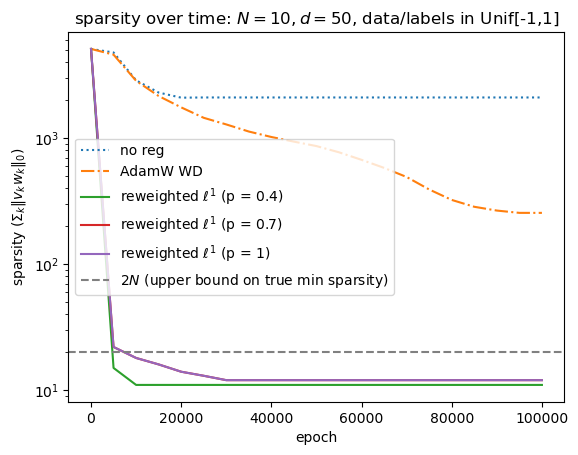

In [5]:
# Plot sparsity over time
plt.figure()
labels = ['no reg', 'AdamW WD',
          'reweighted $\ell^1$ (p = {})'.format(p1), 
          'reweighted $\ell^1$ (p = {})'.format(p2),
          'reweighted $\ell^1$ (p = {})'.format(p3)]
label_idx = 0
for name, style in [('none',':'), ('wd','-.'), ('p1','-'), ('p2', '-'), ('p3', '-')]:
    plt.plot(epochs, metrics[name]['spars'], style, label=labels[label_idx])
    label_idx = label_idx + 1
plt.xlabel('epoch')
plt.ylabel('sparsity ($\Sigma_k \| v_k w_k \|_0$)')
plt.yscale('log')
plt.axhline(y=2*N, color='gray', linestyle='--', label='$2N$ (upper bound on true min sparsity)')
plt.title('sparsity over time: $N = {}, d = {}$, data/labels in Unif[-1,1]'.format(N,D))
plt.legend()
fig_path = fig_dir + 'sparsity_over_time_high_d.png'
if save_figs:
    plt.savefig(fig_path, dpi=300)
plt.show()
